# LSTM Model Comparison With Data From Different Domains

In [52]:
import sys
import os

# Add the project root (one level up from 'notebooks') to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [53]:
# Imports from our src/ modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import autocorrelation_plot

from src.data.load_fin_data import load_finance_data, load_fred_data
from src.data.preprocess_fin_data import enrich_target_stock, flatten_cols
from src.data.make_dataset import train_test_split
from src.data.split_sequences import prepare_train_val_test
from src.models.base_ARIMA import build_arima_model
from src.models.DL_LSTM import build_lstm_model, create_sequences, prepare_lstm_data, plot_predictions, evaluate_predictions

from src.evaluation.evaluate import evaluate_model
from src.evaluation.metrics import generate_model_metrics
from src.data.scaler_utils import get_scaler
from src.data.adjusted_r2 import adjusted_r2

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler

from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

In [76]:
# load parquet data to pandas dataframe
combined_data = pd.read_parquet('../data/dataset_retail/processed/data_no_lags_s1_i1.parquet')
combined_data	= combined_data.drop(columns=['split'])
target = 'sales'

combined_data

,date,sales,year,month,day,dayofweek,dayofyear,weekofyear,quarter,is_month_start,is_month_end
0,2013-01-01,13,2013,1,1,1,1,1,1,1,0
1,2013-01-02,11,2013,1,2,2,2,1,1,0,0
2,2013-01-03,14,2013,1,3,3,3,1,1,0,0
3,2013-01-04,13,2013,1,4,4,4,1,1,0,0
4,2013-01-05,10,2013,1,5,5,5,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,14,2017,12,27,2,361,52,4,0,0
1822,2017-12-28,19,2017,12,28,3,362,52,4,0,0
1823,2017-12-29,15,2017,12,29,4,363,52,4,0,0
1824,2017-12-30,27,2017,12,30,5,364,52,4,0,0


In [71]:
combined_data = pd.read_csv('../data/dataset_energy/combined_df_with_features.csv.gz')
target = 'Energy_Demand'

combined_data

,Energy_Demand,Energy_Price,Crude_Oil_Price,Natural_Gas_Price,Rainfall,Carbon_Intensity,Renewable_Energy_Percentage,Temperature,Solar_Exposure,hour,dayofweek,month,lag_1,lag_12,lag_288,lag_576,rolling_mean_24,rolling_std_24
0,7294.03,4.370966,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,7304.76,4.507557,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,4.371,NaN,NaN,NaN,NaN,NaN
2,7176.53,4.476996,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,4.508,NaN,NaN,NaN,NaN,NaN
3,7247.72,4.497028,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,4.477,NaN,NaN,NaN,NaN,NaN
4,7169.96,4.478132,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,4.497,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296679,7467.70,4.900523,74.58,3.40,0.0,202.82,73.07,22,0,23,1,12,4.894,4.730,4.901,4.687,4.736,0.094
296680,7393.27,4.967171,74.58,3.40,0.0,202.82,73.07,22,0,23,1,12,4.901,4.715,4.817,4.478,4.746,0.098
296681,7360.53,4.888091,74.58,3.40,0.0,202.82,73.07,22,0,23,1,12,4.967,4.722,4.730,4.591,4.759,0.106
296682,7345.74,4.894027,74.58,3.40,0.0,202.82,73.07,22,0,23,1,12,4.888,4.703,4.714,4.483,4.768,0.107


In [ ]:
combined_data = pd.read_csv('../data/dataset_energy/combined_df_with_features.csv.gz')
target = 'Energy_Demand'

combined_data

In [66]:
# combined_data = pd.read_csv('../data/dataset_transport/Baltimore.csv')
# target = 'Total TEUs'

url = "https://opendata.maryland.gov/resource/2ir4-626w.csv"
combined_data = pd.read_csv(url)

# Convert the 'month' column to datetime and extract year-month in 'YYYY-MM' format
combined_data['month'] = pd.to_datetime(combined_data['month']).dt.strftime('%Y%m').astype(int)

# Set the forecasting target
target = 'total_teus'

# # export data to csv
# combined_data.to_csv('../data/dataset_transport/combined_df_with_features.csv', index=False)

combined_data


,month,total_container_tons,total_automobile_tons,total_ro_ro_tons,forest_products_break_bulk_,steel_amp_other_metals_tons,total_breakbulk_tons,total_general_cargo_tons,imported_loaded_teus,export_loaded_teus,...,import_empty_teus,export_empty_teus,total_empty_teus,total_teus,total_containers,import_auto_units,export_auto_units,total_auto_units,import_ro_ro_tons,export_ro_ro_tons
0,202502,623059.0,74053.0,56119.0,43076.0,752.0,12024.0,809083.0,44158.0,15131.0,...,187.0,30932.0,31119.0,90408.0,52363.0,24068.0,8377.0,32445.0,40890.0,15229.0
1,202501,731814.0,62891.0,57894.0,44197.0,680.0,11714.0,909190.0,48004.0,17365.0,...,224.0,25113.0,25337.0,90706.0,53878.0,22487.0,8544.0,31031.0,41364.0,16530.0
2,202412,727972.0,107839.0,66784.0,48758.0,537.0,15307.0,967197.0,48036.0,18287.0,...,16.0,29195.0,29211.0,95534.0,55644.0,27943.0,9761.0,37704.0,51287.0,15497.0
3,202411,719903.0,112552.0,84434.0,71229.0,902.0,17902.0,1006922.0,44375.0,21030.0,...,83.0,20478.0,20561.0,85966.0,50420.0,37713.0,7524.0,45237.0,65513.0,18921.0
4,202410,526700.0,72803.0,56889.0,23489.0,417.0,7200.0,687498.0,37221.0,12053.0,...,94.0,22839.0,22933.0,72207.0,42427.0,21364.0,9838.0,31202.0,45205.0,11684.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,199805,382760.0,25824.0,40905.0,25530.0,4022.0,37509.0,516550.0,18178.0,17104.0,...,2407.0,3242.0,5626.0,40908.0,26250.0,15081.0,1790.0,16871.0,28865.0,12040.0
322,199804,377397.0,21900.0,56087.0,48180.0,5663.0,33094.0,542321.0,17777.0,18157.0,...,2712.0,3070.0,5769.0,41703.0,25985.0,11715.0,2342.0,14057.0,39312.0,16775.0
323,199803,377748.0,27610.0,57077.0,43910.0,10344.0,31001.0,547690.0,18577.0,18570.0,...,5906.0,3525.0,9431.0,46578.0,28926.0,14570.0,2967.0,17537.0,40470.0,16607.0
324,199802,359722.0,20085.0,37156.0,42726.0,13805.0,31879.0,505373.0,16228.0,16846.0,...,3045.0,2056.0,5101.0,38175.0,23874.0,11206.0,1393.0,12599.0,23405.0,13751.0


In [67]:
import pandas as pd
import numpy as np
import yfinance as yf
from fredapi import Fred

# -------------------------------
# Setup
# -------------------------------
FRED_API_KEY = '92300a5052e3ca2facec21726fc18b04'
fred = Fred(api_key=FRED_API_KEY)

start = "2015-01-01"
end = "2025-01-01"

# -------------------------------
# Load Maryland TEU Data (Keep all columns)
# -------------------------------
df_md = pd.read_csv("https://opendata.maryland.gov/resource/2ir4-626w.csv")
df_md['month'] = pd.to_datetime(df_md['month'])
df_md['year_month'] = df_md['month'].dt.strftime('%Y%m').astype(int)
df_md['month_num'] = df_md['month'].dt.month

# Cyclical encoding for month
df_md['month_sin'] = np.sin(2 * np.pi * df_md['month_num'] / 12)
df_md['month_cos'] = np.cos(2 * np.pi * df_md['month_num'] / 12)

df_teu = df_md.copy()  # full data retained

# -------------------------------
# Load FRED Indicators
# -------------------------------
fred_series = {
    'CPIAUCNS': 'CPI_All_Items',
    'CPILFESL': 'CPI_Core',
    'INDPRO': 'Industrial_Production',
    'TOTALSA': 'Vehicle_Sales',
    'UMCSENT': 'Consumer_Sentiment',
    'UNRATE': 'Unemployment_Rate'
}

fred_dfs = []
for series_id, name in fred_series.items():
    data = fred.get_series(series_id, observation_start=start, observation_end=end)
    df = pd.DataFrame(data, columns=[name])
    df.index = pd.to_datetime(df.index)
    df = df.resample("MS").ffill()
    df["year_month"] = df.index.strftime('%Y%m').astype(int)
    fred_dfs.append(df.reset_index(drop=True))

df_fred = fred_dfs[0]
for df in fred_dfs[1:]:
    df_fred = df_fred.merge(df, on="year_month", how="outer")

# -------------------------------
# Load Yahoo Finance Indicators
# -------------------------------
yahoo_series = {
    'CL=F': 'Crude_Oil',
    '^DJT': 'Dow_Transport_Avg'
}

yahoo_dfs = []
for ticker, name in yahoo_series.items():
    df = yf.download(ticker, start=start, end=end, interval="1mo")

    # 🛠 Flatten MultiIndex if it exists
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df = df[["Close"]].rename(columns={"Close": name})
    df = df.reset_index()
    df["year_month"] = df["Date"].dt.strftime('%Y%m').astype(int)
    df = df[["year_month", name]]
    yahoo_dfs.append(df)

df_yahoo = yahoo_dfs[0]
for df in yahoo_dfs[1:]:
    df_yahoo = df_yahoo.merge(df, on="year_month", how="outer")

# -------------------------------
# Combine All Sources
# -------------------------------
df_combined = df_teu.merge(df_fred, on="year_month", how="left")
df_combined = df_combined.merge(df_yahoo, on="year_month", how="left")

# -------------------------------
# Create Lagged Features Version
# -------------------------------
df_lagged = df_combined.copy()
lag_columns = [col for col in df_lagged.columns if col not in ['year_month', 'month', 'port', 'freight_type']]
for col in lag_columns:
    df_lagged[f'{col}_lag1'] = df_lagged[col].shift(1)
    df_lagged[f'{col}_lag3'] = df_lagged[col].shift(3)

df_lagged = df_lagged.dropna().reset_index(drop=True)
df_no_lag = df_combined.dropna().reset_index(drop=True)

# -------------------------------
# Save Both Versions
# -------------------------------
# df_lagged.to_csv("../data/dataset_transport/maryland_teu_enhanced_lagged.csv", index=False)
# df_no_lag.to_csv("../data/dataset_transport/maryland_teu_enhanced_no_lag.csv", index=False)
# print("Saved: maryland_teu_enhanced_lagged.csv and maryland_teu_enhanced_no_lag.csv")

# Optional: assign for reuse
combined_data = df_no_lag


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [69]:
import pandas as pd
import numpy as np
import yfinance as yf
from fredapi import Fred
import requests

# -------------------------------
# Setup
# -------------------------------
FRED_API_KEY = '92300a5052e3ca2facec21726fc18b04'
fred = Fred(api_key=FRED_API_KEY)

start = "2015-01-01"
end = "2025-01-01"

# -------------------------------
# Load Port of LA TEU Data
# -------------------------------
url_la = "https://kentico.portoflosangeles.org/getportdata?data=containers"
res = requests.get(url_la).json()
df_la = pd.DataFrame(res["MonthlyContainerVolumes"])

# Convert Year + Month to datetime
df_la["month"] = pd.to_datetime(df_la["Year"].astype(str) + "-" + df_la["Month"].astype(str).str.zfill(2))
df_la["year_month"] = df_la["month"].dt.strftime('%Y%m').astype(int)
df_la["month_num"] = df_la["month"].dt.month

# Cyclical encoding for month
df_la["month_sin"] = np.sin(2 * np.pi * df_la["month_num"] / 12)
df_la["month_cos"] = np.cos(2 * np.pi * df_la["month_num"] / 12)

# Calculate total TEU
df_la["total_teus"] = df_la[["LoadedIn", "LoadedOut", "EmptyIn", "EmptyOut"]].astype(float).sum(axis=1)

# Optional: add port name
df_la["port"] = "Los Angeles"

# -------------------------------
# Load FRED Indicators
# -------------------------------
fred_series = {
    'CPIAUCNS': 'CPI_All_Items',
    'CPILFESL': 'CPI_Core',
    'INDPRO': 'Industrial_Production',
    'TOTALSA': 'Vehicle_Sales',
    'UMCSENT': 'Consumer_Sentiment',
    'UNRATE': 'Unemployment_Rate'
}

fred_dfs = []
for series_id, name in fred_series.items():
    data = fred.get_series(series_id, observation_start=start, observation_end=end)
    df = pd.DataFrame(data, columns=[name])
    df.index = pd.to_datetime(df.index)
    df = df.resample("MS").ffill()
    df["year_month"] = df.index.strftime('%Y%m').astype(int)
    fred_dfs.append(df.reset_index(drop=True))

df_fred = fred_dfs[0]
for df in fred_dfs[1:]:
    df_fred = df_fred.merge(df, on="year_month", how="outer")

# -------------------------------
# Load Yahoo Finance Indicators
# -------------------------------
yahoo_series = {
    'CL=F': 'Crude_Oil',
    '^DJT': 'Dow_Transport_Avg',
    '^GSPC': 'S&P_500',
    'SOXX': 'Semiconductor_ETF',
    'IYT': 'Transport_Sector_ETF'
}

yahoo_dfs = []
for ticker, name in yahoo_series.items():
    df = yf.download(ticker, start=start, end=end, interval="1mo")

    # 🛠 Flatten MultiIndex if it exists
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df = df[["Close"]].rename(columns={"Close": name})
    df = df.reset_index()
    df["year_month"] = df["Date"].dt.strftime('%Y%m').astype(int)
    df = df[["year_month", name]]
    yahoo_dfs.append(df)

df_yahoo = yahoo_dfs[0]
for df in yahoo_dfs[1:]:
    df_yahoo = df_yahoo.merge(df, on="year_month", how="outer")

# -------------------------------
# Combine All Sources
# -------------------------------
df_combined = df_la.merge(df_fred, on="year_month", how="left")
df_combined = df_combined.merge(df_yahoo, on="year_month", how="left")

# -------------------------------
# Create Lagged Features Version
# -------------------------------
df_lagged = df_combined.copy()
lag_columns = [col for col in df_lagged.columns if col not in ['year_month', 'month', 'port']]
for col in lag_columns:
    df_lagged[f'{col}_lag1'] = df_lagged[col].shift(1)
    df_lagged[f'{col}_lag3'] = df_lagged[col].shift(3)

df_lagged = df_lagged.dropna().reset_index(drop=True)
df_no_lag = df_combined.dropna().reset_index(drop=True)

# -------------------------------
# Save Both Versions
# -------------------------------
# df_lagged.to_csv("../data/dataset_transport/la_teu_enhanced_lagged.csv", index=False)
# df_no_lag.to_csv("../data/dataset_transport/la_teu_enhanced_no_lag.csv", index=False)
# print("✅ Saved: la_teu_enhanced_lagged.csv and la_teu_enhanced_no_lag.csv")

combined_data = df_no_lag


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
# metrics_scores = {}
# metrics_scores[target_ticker] = {"RMSE": rmse, "MSE": mse, "MAE": mae, "MAPE": mape, "R2": r2, "Adj_R2": adj_r2}
# metrics_df = pd.DataFrame(metrics_scores).T  # Transpose so models are rows
# # metrics_df.to_csv("model_metrics_scores.csv")
# print(metrics_df)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0406 - val_loss: 0.0389
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0157 - val_loss: 0.0474
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0140 - val_loss: 0.0312
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0123 - val_loss: 0.0202
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0130 - val_loss: 0.0201
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0125 - val_loss: 0.0210
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0119 - val_loss: 0.0183
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0126 - val_loss: 0.0158
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0131 - val_loss: 0.0218
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0118 - val_loss: 0.0150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


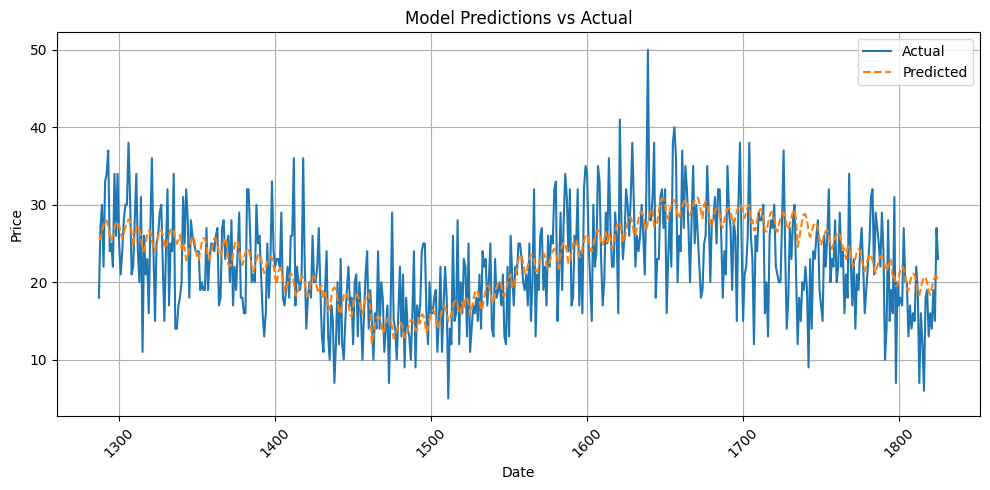

RMSE: 5.637, MAE: 4.445, R²: 0.295


In [77]:
# LSTM Model

# Step 1: Prepare your dataset
X_train, X_test, y_train, y_test, scaler, date_index = prepare_lstm_data(combined_data, target, 30, 0.3)

# Step 2: Build and train the model
n_features = X_train.shape[2]
model = build_lstm_model(30, n_features=n_features)

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Step 3: Predict and evaluate
y_pred = model.predict(X_test)

# Determine the correct number of columns from the scaler
n_total_features = scaler.n_features_in_

# Pad predictions with zeros for inverse transform
y_pred_full = np.zeros((len(y_pred), n_total_features))
y_pred_full[:, -1] = y_pred.flatten()

y_test_full = np.zeros((len(y_test), n_total_features))
y_test_full[:, -1] = y_test.flatten()

# Inverse transform and extract only the target column
y_pred_inv = scaler.inverse_transform(y_pred_full)[:, -1]
y_test_inv = scaler.inverse_transform(y_test_full)[:, -1]

# Step 4: Plot results
plot_predictions(date_index, y_test_inv, y_pred_inv)

# Step 5: Print metrics
rmse, mae, r2 = evaluate_predictions(y_test_inv, y_pred_inv)
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")